In [5]:
import pandas as pd
import yaml
import ast
import numpy as np
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/results.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    # drop all columns with name kids in it
    df = df.loc[:, ~df.columns.str.contains('kids')]
else:
    df = df.loc[:, ~df.columns.str.contains('adults')]
df.rename(columns={'Unnamed: 0': 'class'}, inplace=True)

In [6]:
df = df[['no cutoff - adults', 'class','city_country']].dropna()

In [7]:
# line chart for ALL for F1 score by city_country
# ['ALL', 'AML', 'APL']
# df = df[df['class'] == 'APL']
x = df['no cutoff - adults'].iloc[0]
# x is a string convert to dict
eval(x)['F1 Score'][0]

# do it for the entrie df


# Safely evaluate and extract the F1 Score, handling potential NaN and malformed data
def safe_eval_f1_score(row):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        data = ast.literal_eval(row)
        return data['F1 Score'][0]
    except (ValueError, SyntaxError, KeyError, TypeError):
        # Return NaN if eval or accessing the dictionary fails
        return np.nan

# Apply the function to the entire DataFrame
df['F1 Score'] = df['no cutoff - adults'].apply(lambda x: safe_eval_f1_score(x) if pd.notna(x) else np.nan)

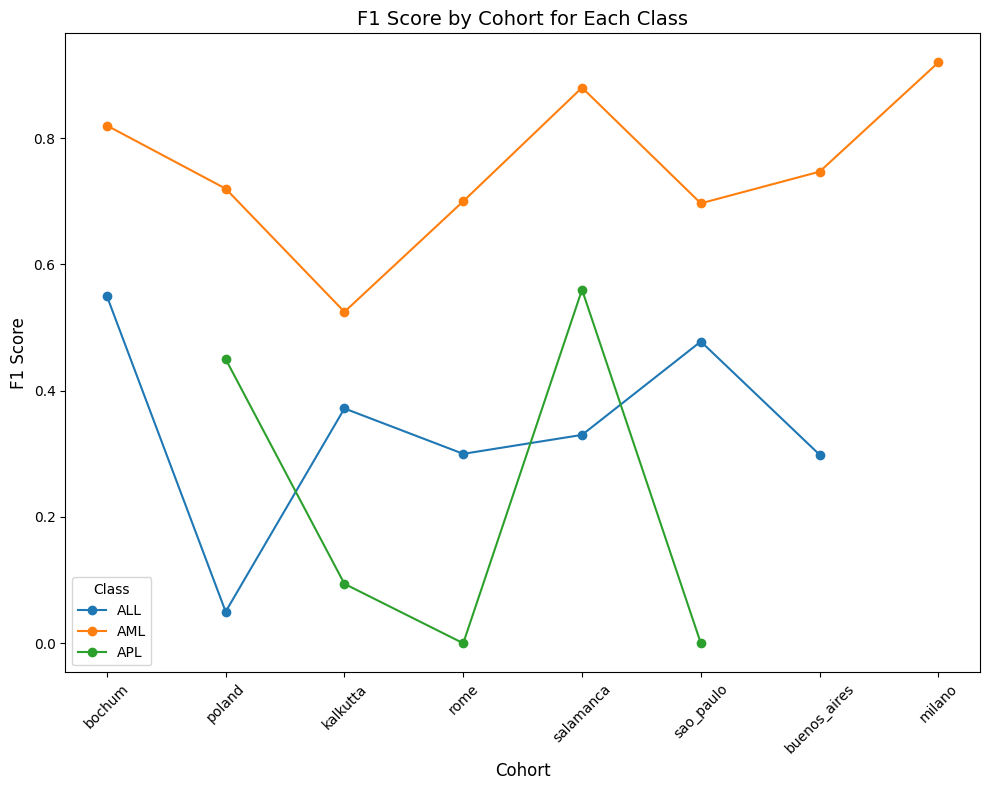

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Group the dataframe by 'class'
grouped = df.groupby('class')

# Create a plot for each class
plt.figure(figsize=(10, 8))

for class_name, group in grouped:
    plt.plot(group['city_country'], group['F1 Score'], marker='o', linestyle='-', label=class_name)

# Add title and labels
plt.title('F1 Score by Cohort for Each Class', fontsize=14)
plt.xlabel('Cohort', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)

# Show legend
plt.legend(title="Class")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()